# 자전거 대여수 예측
- X(주변 환경 특성들)로부터 대여수 y 예측
 - 데이터의 순서 정보는 무시
- 시계열 데이터로 보고 선형예측
 - split_seq, walk_forward 모델
 - 데이터의 순서 정보를 사용
- Prophet으로 예측
- 신경망 (MLP, LSTM) 을 이용하는 방법
- 앙상블 기법: 여러 모델을 만든후 평균치를 구한다

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'

# 데이터 다운로드

In [110]:
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
df[:3]
# to_datetime() 호출하지 않아도 된다. 읽으면서 바로 날짜 형식으로 읽는다

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 날짜 데이터 분해

In [112]:
df['datetime'].dt.year

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [113]:
df['datetime'].dt.year

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
10881    2012
10882    2012
10883    2012
10884    2012
10885    2012
Name: datetime, Length: 10886, dtype: int64

In [114]:
df["d-year"] = df["datetime"].dt.year
df["d-month"] = df["datetime"].dt.month
df["d-day"] = df["datetime"].dt.day
df["d-hour"] = df["datetime"].dt.hour
df["d-dayofweek"] = df["datetime"].dt.dayofweek

df[["datetime", "d-year", "d-month", "d-day", "d-hour","d-dayofweek" ]].head()

,datetime,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,2011,1,1,0,5
1,2011-01-01 01:00:00,2011,1,1,1,5
2,2011-01-01 02:00:00,2011,1,1,2,5
3,2011-01-01 03:00:00,2011,1,1,3,5
4,2011-01-01 04:00:00,2011,1,1,4,5


<AxesSubplot:xlabel='d-hour', ylabel='count'>

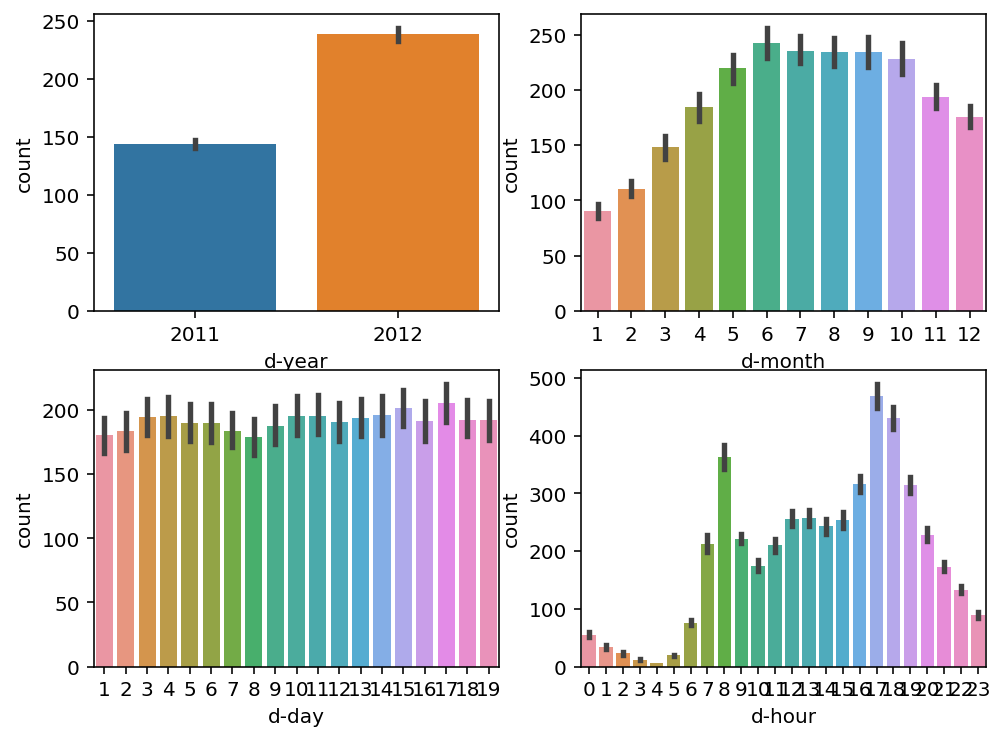

In [115]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
              figsize=(8,6))
sns.barplot(data=df, x="d-year", y="count", ax=ax1)
sns.barplot(data=df, x="d-month", y="count", ax=ax2)
sns.barplot(data=df, x="d-day", y="count", ax=ax3)
sns.barplot(data=df, x="d-hour", y="count", ax=ax4)

<AxesSubplot:xlabel='d-hour', ylabel='count'>

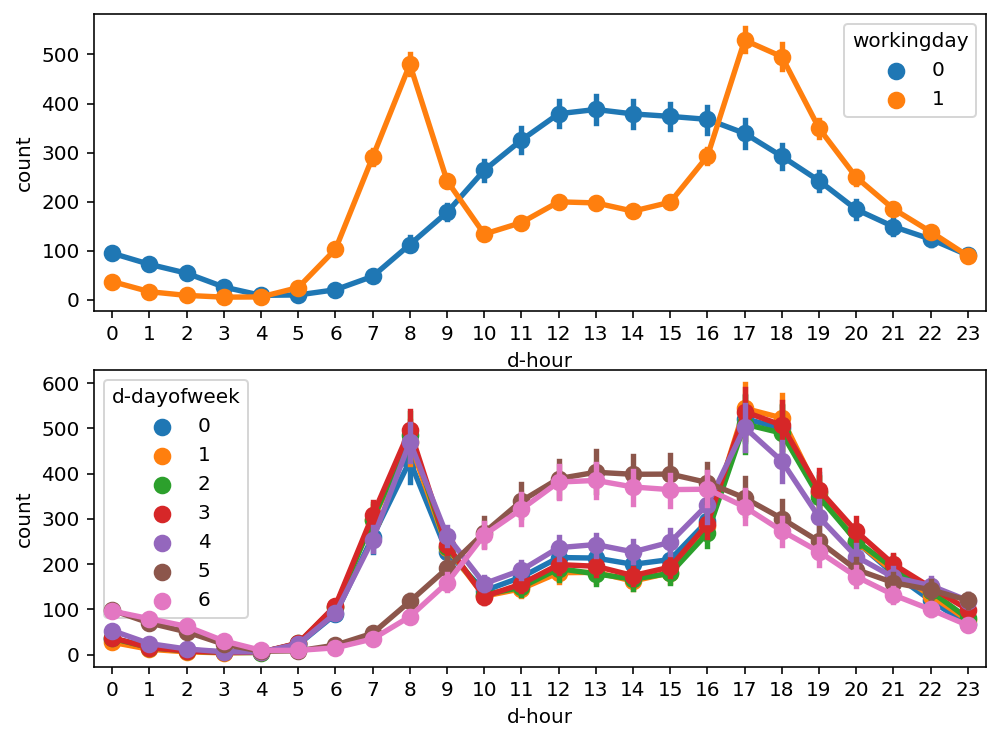

In [116]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(8, 6)

sns.pointplot(data=df, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=df, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 훈련에 사용할 특성 선택

In [117]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-dayofweek'],
      dtype='object')

In [118]:
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,d-year,d-month,d-day,d-hour,d-dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5


In [119]:
features = ['season', 'holiday', 'workingday', 'temp', 'atemp','weather', 'windspeed', 'd-day', 'd-hour', 'd-dayofweek']

features = ["season", "holiday", "workingday", "d-hour"]

## X -> y 모델
- 랜덤 포레스트
- 지금은 시계열 데이터 예측이 아니므로 데이터를 셔플링하여 훈련/검증하겠다 (train_test_split)

In [120]:
X = df[features]
X[:3]

,season,holiday,workingday,d-hour
0,1,0,0,0
1,1,0,0,1
2,1,0,0,2


In [121]:
# X = df[features]
y = df['count'] # 시리즈
# 데이터를 랜덤하게 섞어서 훈련/검증 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [122]:
y.values

array([ 16,  40,  32, ..., 168, 129,  88])

In [123]:
model = RandomForestRegressor(n_estimators= 100)
model.fit(X_train, y_train)
model.score(X_test, y_test) # R2

0.7432885759607498

### 주요 특성 변수

In [124]:
def show_feature_importances(features, importances):
    df = pd.DataFrame({'feature':features,'importance':importances})
    df = df.sort_values('importance', ascending=False)
    ypos = np.arange(len(df.feature))

    plt.figure(figsize=(6,4))
    plt.barh(df.feature, df.importance)
    plt.yticks(ypos, df.feature)
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.xlim(0, 1)
    plt.ylim(-1, len(df.feature))
    plt.show()

In [125]:
model.feature_importances_

array([0.12137528, 0.00574061, 0.11667921, 0.7562049 ])

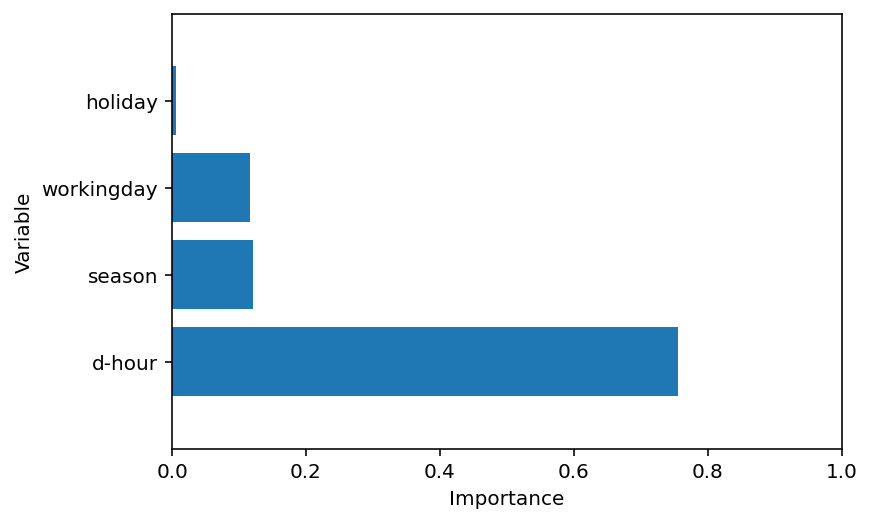

In [126]:
show_feature_importances(features, model.feature_importances_)

### 시각화 함수

In [127]:
y_test

9437     635
6564     297
10510    721
7958      80
3564     129
        ... 
10291     39
9559     374
7607     650
8589     152
1051     257
Name: count, Length: 2722, dtype: int64

In [128]:
# 주의 아래의 y_test, y_pred 은 ndarray 타입이어야 한다 (리스트나, 데이터프레임, 시리즈은 오류발생)
# df.values, np.array(리스트)
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    print("MAE=", np.abs(error).mean().round(4))
    print("RMSE=", mean_squared_error(y_test, y_pred, squared=False).round(4))
    print("MAPE=", ((1-np.abs(error)/y_test)*100).mean().round(4),"%")
    print("max error=", max(error).round(4))
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    #  잔차  (residue) 산포도
    plt.scatter(y_test, error, s=5)
#     plt.scatter(y_pred, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

In [139]:
X_test.shape

(2722, 4)

In [140]:
y_pred.shape

(2722,)

In [142]:
1-mean_absolute_percentage_error(y_test, y_pred)

0.3984407103271147

R2= 0.7433
MAE= 59.701
RMSE= 91.3102
MAPE= 39.8441 %
max error= 463.9782


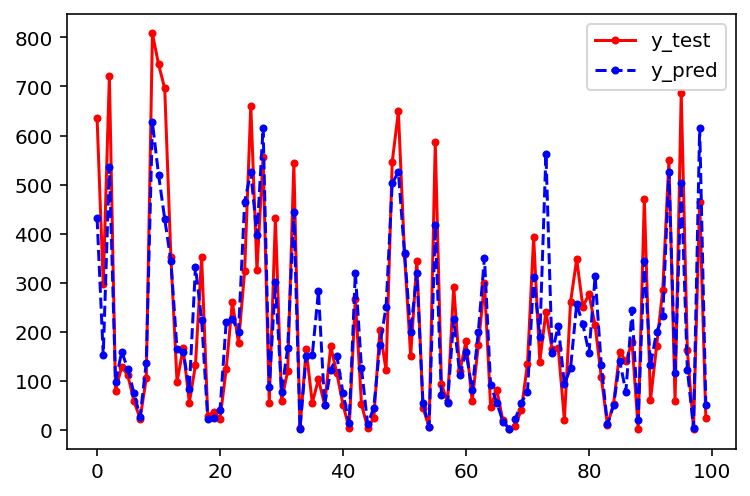

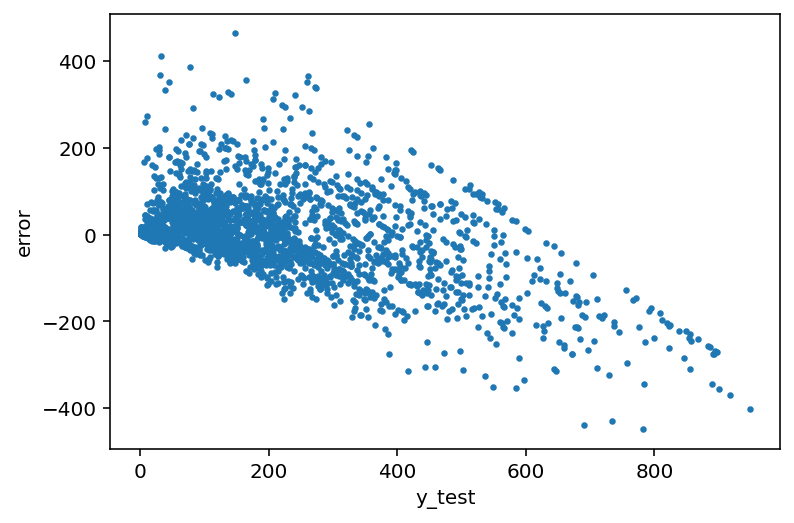

In [143]:
y_pred = model.predict(X_test)
show_regression_result(y_test.values, y_pred,100)

In [144]:
y_test.shape, y_pred.shape

((2722,), (2722,))

In [145]:
np.vstack((y_test[:10], y_pred[:10].round(1))).T

array([[635. , 431.5],
       [297. , 152.8],
       [721. , 536.7],
       [ 80. ,  97.4],
       [129. , 159.4],
       [111. , 124.1],
       [ 58. ,  74.4],
       [ 23. ,  26.9],
       [105. , 137.1],
       [808. , 626.5]])

In [ ]:
# 과제: X의 특성 선택을 잘 하여, 성능을 높여보자 > 0.74

# 선형 모델

In [ ]:
count = df["count"].values

In [ ]:
plt.plot(count[:100])

In [ ]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [ ]:
# 입력 윈도우 n_steps_in, 멀티스텝 출력 n_steps_out
def split_seq_2(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[out_end_ix-1]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y)

In [ ]:
z = np.arange(15)
split_seq_2(z, 5 ,4)

## 적절한 n_steps_in 찾기

In [ ]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
for n_steps in range(1,24*20,24):
  x_train, y_train = split_seq_2(train, n_steps, 1)
  x_test, y_test = split_seq_2(test, n_steps, 1)
  lr.fit(x_train, y_train) 
  print(n_steps, lr.score(x_test, y_test).round(4))

### 최적값 선택

In [ ]:
n_steps = 10*24
x_train, y_train = split_seq_2(train, n_steps, 1)
x_test, y_test = split_seq_2(test, n_steps, 1)
lr.fit(x_train, y_train) 
print(n_steps, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
show_regression_result(y_test, y_pred)

- 1시간 후를 예측했으므로 정확하다

## 미래 예측

In [ ]:
lr = LinearRegression()
n_steps_in = 10*24
n_futures = [1,24, 24*7, 24*7*2, 24*7*3]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))

## 최적값 선택 in, out

In [ ]:
n_steps_in = 24*10
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

In [131]:
lr.coef_

array([ 6.37917435e-02,  3.32557385e-03,  1.38618144e-02, -2.23027426e-02,
       -4.04429234e-02, -4.44489741e-02, -2.92619195e-02, -3.80405335e-02,
        2.40576493e-02, -8.22131186e-03,  5.34192877e-03, -5.41716690e-03,
        1.36222103e-02,  9.41780925e-03,  8.99432098e-03, -1.03859588e-02,
        1.44122599e-02, -1.58063362e-02, -6.50192072e-03, -1.17412226e-02,
       -8.77162899e-05, -5.95419535e-03,  2.28830659e-02,  7.32660389e-02,
       -1.64263125e-02,  6.11249295e-02,  1.86095332e-02,  1.16275257e-02,
       -1.73511377e-03,  3.11397731e-03, -1.29618981e-02, -1.73723563e-02,
       -6.95060101e-03, -3.58437242e-03, -1.60209748e-02,  7.57920948e-03,
       -4.32233277e-03, -6.11796910e-03,  1.57070345e-02, -1.06892740e-02,
        1.60738726e-02,  2.55064672e-02, -2.82324331e-03,  1.69652649e-02,
        1.66568890e-02,  5.66885568e-03,  1.08596487e-02, -1.19668198e-02,
       -1.71904252e-02,  1.92696365e-02,  1.42079265e-02, -2.36401113e-03,
        1.59100438e-03, -

In [132]:
y_pred = lr.predict(x_test)
show_regression_result(y_test, y_pred)

ValueError: operands could not be broadcast together with shapes (2859,) (2722,) 

# Prophet

In [63]:
from fbprophet import Prophet
data = df[["datetime","count"]]
data.columns = ["ds","y"]
data.ds.min(), data.ds.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [64]:
train_data = data[:-24*100]
test_data = data[-24*100:]
model = Prophet()
model.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [65]:
train_data.shape, test_data.shape

((8486, 2), (2400, 2))

In [66]:
test_data

,ds,y
8486,2012-07-14 23:00:00,211
8487,2012-07-15 00:00:00,187
8488,2012-07-15 01:00:00,168
8489,2012-07-15 02:00:00,115
8490,2012-07-15 03:00:00,57
...,...,...
10881,2012-12-19 19:00:00,336
10882,2012-12-19 20:00:00,241
10883,2012-12-19 21:00:00,168
10884,2012-12-19 22:00:00,129


In [67]:
future = test_data[["ds"]]
print(future[:3])
forecast = model.predict(future)

                      ds
8486 2012-07-14 23:00:00
8487 2012-07-15 00:00:00
8488 2012-07-15 01:00:00


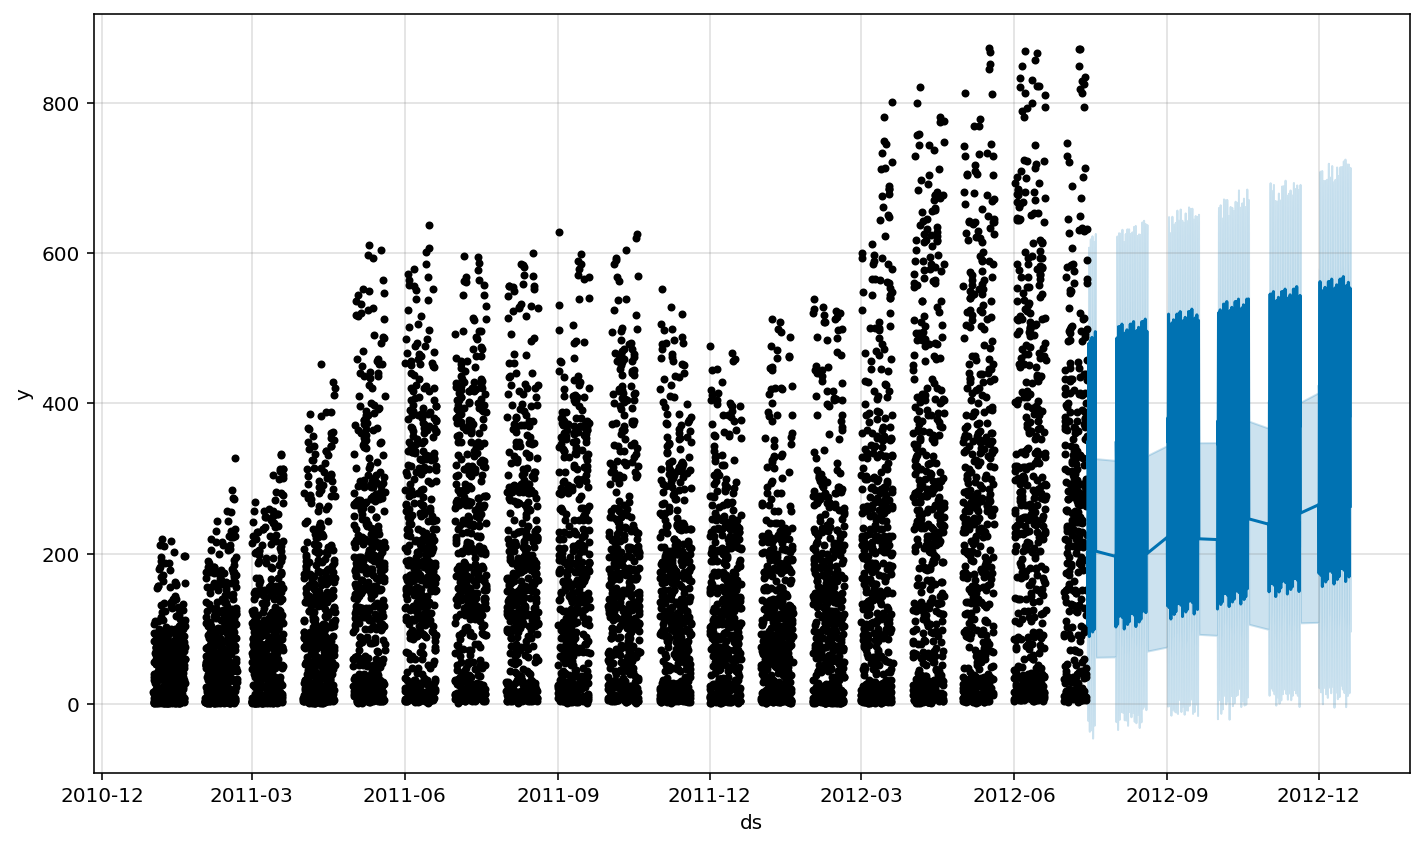

In [68]:
model.plot(forecast)
plt.show()

In [69]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-07-14 23:00:00,291.669813,67.835521,330.936534,291.669813,291.669813,-91.230173,-91.230173,-91.230173,-98.105458,-98.105458,-98.105458,6.875284,6.875284,6.875284,0.0,0.0,0.0,200.439640
1,2012-07-15 00:00:00,291.689641,69.815195,323.933088,291.689641,291.689641,-93.049145,-93.049145,-93.049145,-99.396277,-99.396277,-99.396277,6.347132,6.347132,6.347132,0.0,0.0,0.0,198.640496
2,2012-07-15 01:00:00,291.709469,47.733744,317.289328,291.709469,291.709469,-110.134249,-110.134249,-110.134249,-115.896955,-115.896955,-115.896955,5.762706,5.762706,5.762706,0.0,0.0,0.0,181.575220
3,2012-07-15 02:00:00,291.729297,15.442130,281.928101,291.729297,291.729297,-149.789453,-149.789453,-149.789453,-154.914214,-154.914214,-154.914214,5.124761,5.124761,5.124761,0.0,0.0,0.0,141.939843
4,2012-07-15 03:00:00,291.749124,-20.421756,223.151134,291.749124,291.749124,-187.172733,-187.172733,-187.172733,-191.609483,-191.609483,-191.609483,4.436750,4.436750,4.436750,0.0,0.0,0.0,104.576391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,2012-12-19 19:00:00,366.777661,344.301668,664.110730,279.023541,455.803256,143.360343,143.360343,143.360343,151.325871,151.325871,151.325871,-7.965528,-7.965528,-7.965528,0.0,0.0,0.0,510.138004
2396,2012-12-19 20:00:00,366.797489,261.967146,596.975323,279.015323,455.877051,58.213858,58.213858,58.213858,65.723545,65.723545,65.723545,-7.509687,-7.509687,-7.509687,0.0,0.0,0.0,425.011347
2397,2012-12-19 21:00:00,366.817317,169.478158,498.922053,279.007105,455.950845,-30.816644,-30.816644,-30.816644,-23.819355,-23.819355,-23.819355,-6.997289,-6.997289,-6.997289,0.0,0.0,0.0,336.000672
2398,2012-12-19 22:00:00,366.837144,125.859238,451.091032,278.998886,456.024639,-87.402928,-87.402928,-87.402928,-80.969567,-80.969567,-80.969567,-6.433360,-6.433360,-6.433360,0.0,0.0,0.0,279.434217


In [70]:
y_pred = forecast['yhat'].values
y_test = test_data.y.values

R2= 0.4074
MAE= 142.6925
RMSE= 167.5528
MAPE= -296.6789 %
max error= 445.8388


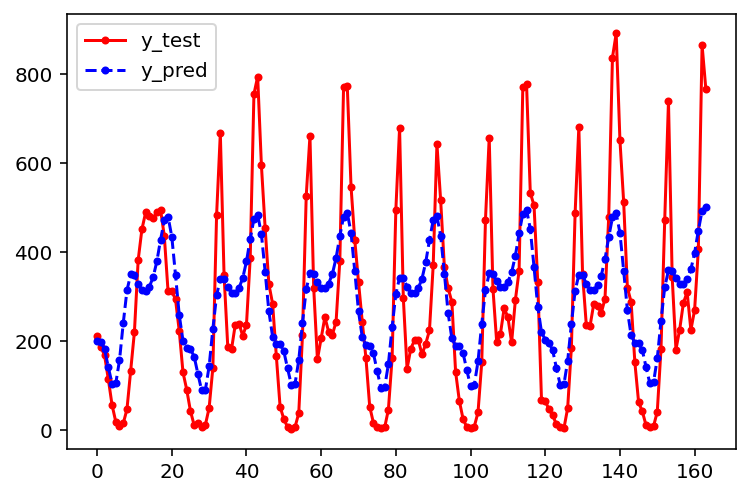

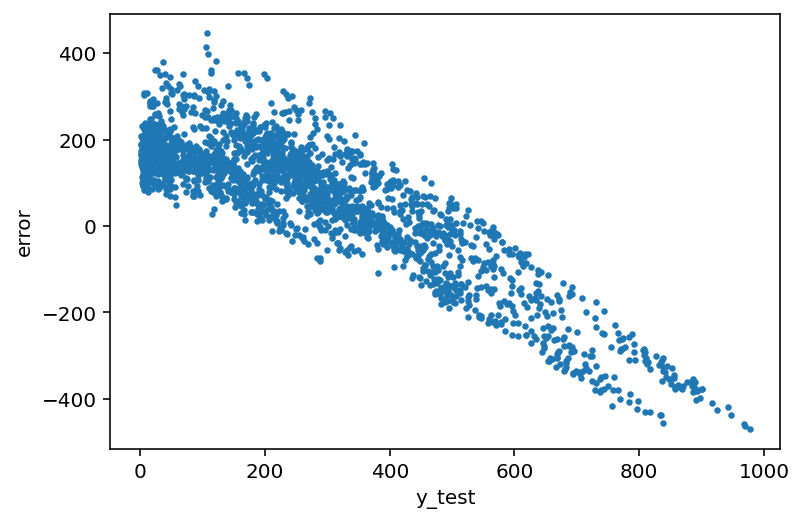

In [71]:
show_regression_result(y_test, y_pred, 164)

## 향 후 3개월간 예측

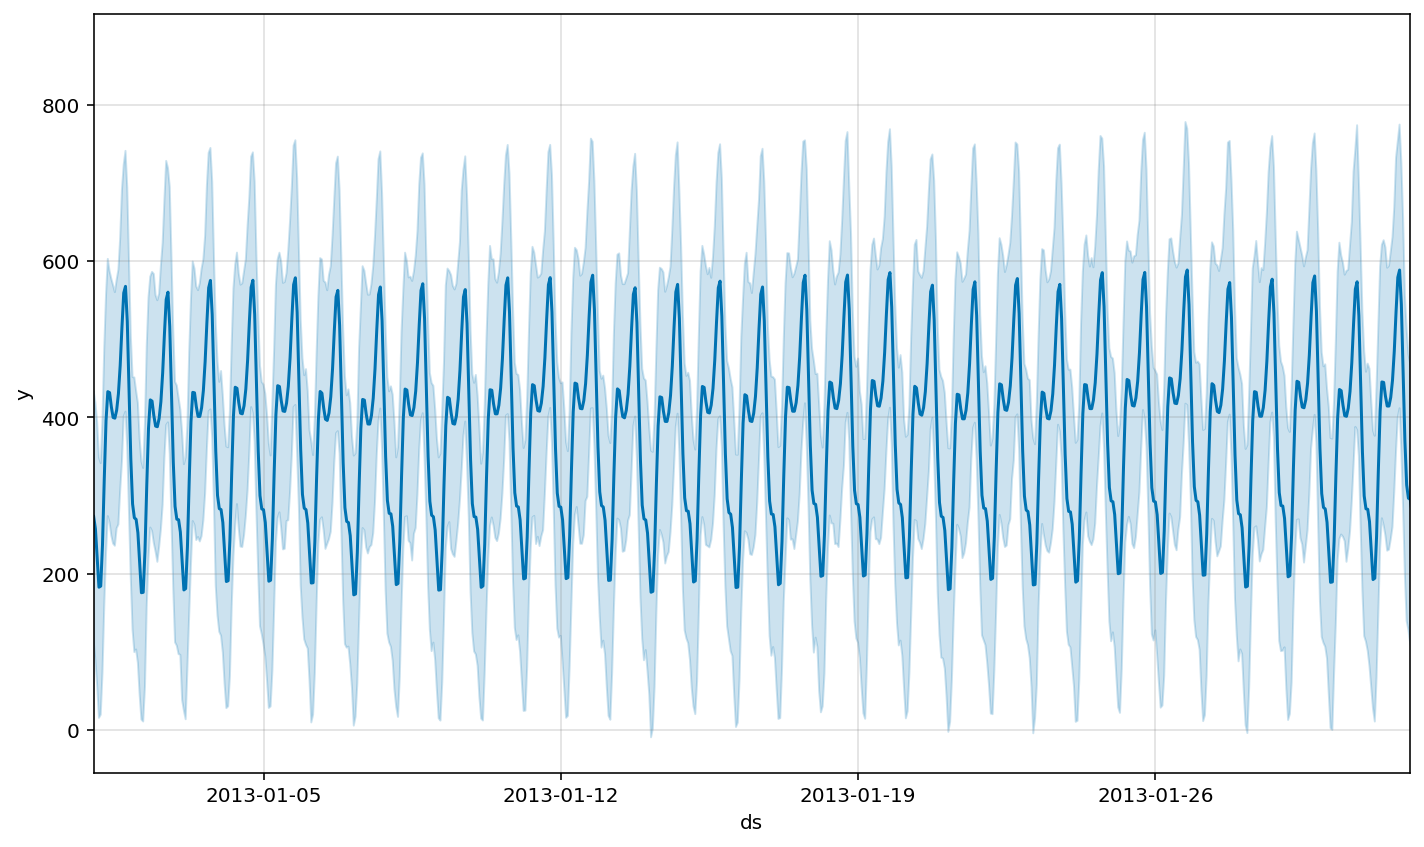

In [74]:
future2 = pd.date_range(start='2013-01-01', end='2013-03-20', 
                       freq='H').to_frame(index=False, name='ds')
forecast = model.predict(future2)
model.plot(forecast)
from datetime import datetime
plt.xlim([datetime(2013, 1, 1), datetime(2013, 2, 1)])
plt.show()


-  정리: X-> y 모델의 성능이 0.74 정도였다 (랜덤포레스트)
- 시계열 모델로는 선형모델이 0.72정도 였다 (단점은 임박한 시점의 데이터가 있다는 가정)
- prophet 모델은 "임의의 기간"에 대해서 예측을 할 수 있다
- 과제: (10800개 데이터가 있다), -2400개 이전 데이터로 학습하고, 마지막 24*100일= 2400 개를 예측하는 
- Prophet 모델을 만들고 성능을 평가하시오 (선형모델과 비교)
